In [2]:
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts

def build_teleportation_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    """
    Builds the quantum circuit for the teleportation protocol.
    
    This circuit teleports the state of a source qubit (s) to a target qubit (b)
    using an entangled Bell pair between an intermediate qubit (a) and the target (b).
    
    Args:
        qr: The QuantumRegister containing the three qubits (s, a, b).
        cr: The ClassicalRegister for the measurements.
        
    Returns:
        The QuantumCircuit for the teleportation protocol.
    """
    # Unpack the qubits and classical bits for clarity
    s, a, b = qr
    c0, c1, c2 = cr

    qc = QuantumCircuit(qr, cr)

    # Step 1: Create the Bell pair between Alice's qubit 'a' and Bob's qubit 'b'
    # This entangled pair is the quantum channel for teleportation.
    qc.h(a)
    qc.cx(a, b)
    qc.barrier()

    # Step 2: Alice's operations
    # Alice entangles her source qubit 's' with her half of the Bell pair 'a'.
    qc.cx(s, a)
    qc.h(s)
    qc.barrier()

    # Step 3: Alice's measurements
    # Alice measures her qubits 's' and 'a' and "sends" the classical results to Bob.
    qc.measure(s, c1)
    qc.measure(a, c0)
    qc.barrier()

    # Step 4: Bob's conditional operations (the "decoding")
    # Bob applies gates to his qubit 'b' based on the classical bits received from Alice.
    # The 'if_test' dynamically applies gates based on measurement outcomes.
    with qc.if_test((c1, 1)):  # If the first classical bit (from s) is 1, apply Z.
        qc.z(b)
    with qc.if_test((c0, 1)):  # If the second classical bit (from a) is 1, apply X.
        qc.x(b)
        
    return qc

Final Teleportation Circuit Diagram:


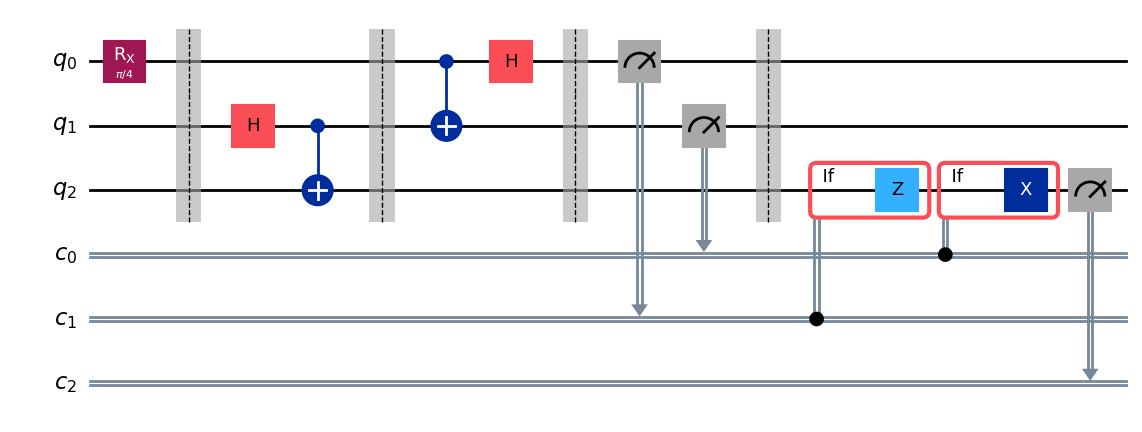


Full measurement counts (c2, c1, c0):


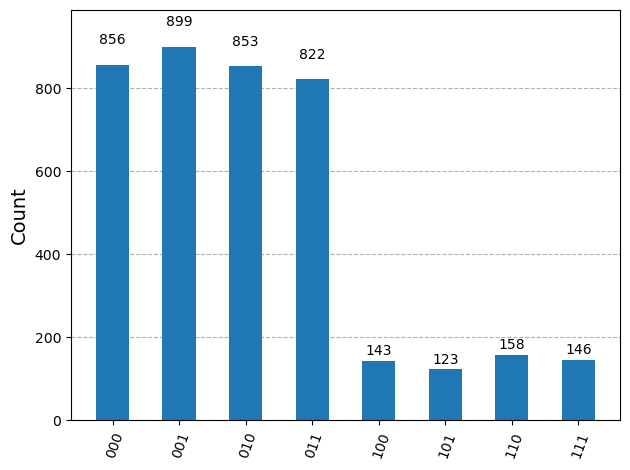


Marginal counts for Bob's qubit (c2):


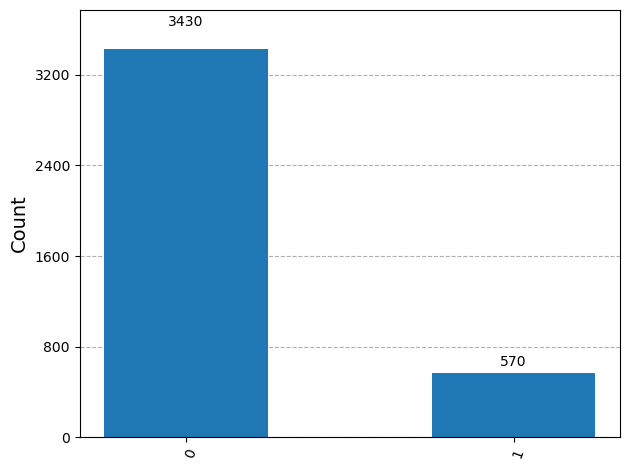

In [3]:


# --- Main Script ---

# 1. Initialize Registers
# q_s: The source qubit whose state we want to teleport.
# q_a: Alice's half of the entangled pair.
# q_b: Bob's half of the entangled pair, which will receive the state.
qr = QuantumRegister(3, name="q")
s, a, b = qr 

# Three classical bits:
# c0, c1 for Alice's measurements, c2 for Bob's final verification.
cr = ClassicalRegister(3, name="c")

# 2. Prepare the Initial State to be Teleported
# We'll prepare the source qubit 's' in a superposition state.
# Here, Rx(pi/4) creates a state that is not |0>, |1>, |+>, or |->.
state_prep_circuit = QuantumCircuit(qr, cr)
state_prep_circuit.rx(math.pi / 4, s)
state_prep_circuit.barrier()

# 3. Build the Main Teleportation Circuit
teleportation_circuit = build_teleportation_circuit(qr, cr)

# 4. Compose the Circuits and Add Final Measurement
# Combine the state preparation with the teleportation logic.
full_circuit = state_prep_circuit.compose(teleportation_circuit)

# Add a final measurement on Bob's qubit to verify the teleported state.
full_circuit.measure(b, cr[2])

# Let's see the final, complete circuit
print("Final Teleportation Circuit Diagram:")
display(full_circuit.draw("mpl", cregbundle=False))


# 5. Simulation and Results
# Set up the simulator
sim = AerSimulator()
shots = 4000
# Transpile the circuit for the simulator backend for better performance
transpiled_circuit = transpile(full_circuit, sim)

# Run the simulation. 'dynamic=True' is needed for circuits with conditional gates.
job = sim.run(transpiled_circuit, shots=shots, dynamic=True)
results = job.result()
counts = results.get_counts()

print("\nFull measurement counts (c2, c1, c0):")
display(plot_histogram(counts))


# 6. Verify the Result
# To confirm the state of 's' was teleported to 'b', we look at the
# probability distribution for Bob's qubit 'b' (measured into c2) alone.
# We marginalize the results to ignore Alice's measurements (c0 and c1).
bobs_marginal_counts = marginal_counts(counts, [qr.index(b)])

# For an initial Rx(pi/4) rotation, the expected probabilities are:
# P(0) = cos^2(pi/8) ≈ 0.8536
# P(1) = sin^2(pi/8) ≈ 0.1464
print("\nMarginal counts for Bob's qubit (c2):")
display(plot_histogram(bobs_marginal_counts))

In [4]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity
from qiskit_aer import AerSimulator


# Create a circuit to generate a Bell state
ideal_circuit = QuantumCircuit(2)
ideal_circuit.h(0)
ideal_circuit.cx(0, 1)

# Get the ideal statevector from the circuit
ideal_state = Statevector(ideal_circuit)

print("Ideal Statevector:\n", np.round(ideal_state.data, 3))



from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create a simple noise model
noise_model = NoiseModel()

# Add depolarizing error to all single-qubit gates
p1_error = 0.01
error_1 = depolarizing_error(p1_error, 1)
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'h'])

# Add depolarizing error to all two-qubit gates
p2_error = 0.05
error_2 = depolarizing_error(p2_error, 2)
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create a simulator backend with the noise model
sim_noise = AerSimulator(noise_model=noise_model)

# Execute the ideal circuit on the noisy simulator
# The result of a noisy simulation is a density matrix
noisy_result = sim_noise.run(ideal_circuit).result()
noisy_state = noisy_result.get_density_matrix()

print("Noisy State (Density Matrix):\n", np.round(noisy_state.data, 3))

Ideal Statevector:
 [0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]


AttributeError: Attribute get_density_matrix is not defined

In [ ]:
# Compute the fidelity between the ideal state and the noisy state
fidelity = state_fidelity(ideal_state, noisy_state)

print(f"\nFidelity of the noisy state against the ideal state: {fidelity:.4f}")